In [1]:
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cpu/torch_nightly.html

Looking in links: https://download.pytorch.org/whl/nightly/cpu/torch_nightly.html


In [2]:
!pip install -q gym ipdb

In [1]:
from collections import deque
import gym, random, math, ipdb
from tqdm import trange
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim


In [2]:
gym.logger.set_level(40)

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
class deep_qnet(nn.Module):
  # in this part we define some features that describes the arcitecture of DQN

  def __init__(self,input_dim=4,output_dim=2,hidden_layer=64):
    

    super(deep_qnet, self).__init__()

    self.input_dim=input_dim
    self.output_dim=output_dim
    self.hidden=hidden_layer
    self.features=nn.Sequential(
        nn.Linear(self.input_dim,self.hidden),
        nn.ReLU(),
        nn.Linear(self.hidden,self.hidden),
        nn.ReLU()
    )
    self.adv=nn.Linear(self.hidden,self.output_dim)
    self.val = nn.Linear(self.hidden, 1)
  def forward(self,x):
    x=self.features(x)
    adv = self.adv(x)
    val = self.val(x)
    return val + adv - adv.mean(1, keepdim=True)

In [15]:
class agent:
  def __init__(self,output_dim = 2,lr = 1e-3,batch_size = 32,gamma=0.99,epsilon=0.15):
    #we initialize our DQN
    self.output_dim=output_dim
    self.lr=lr
    self.batch_size=batch_size
    self.gamma=gamma
    self.epsilon=epsilon
    self.on_net=deep_qnet()
    self.on_net.train()
    self.targ_net=deep_qnet()
    self.update_targ_net()
    for param in self.targ_net.parameters(): param.requires_grad = False
    self.optimiser=optim.Adam(self.on_net.parameters(), lr=self.lr)
  def make_preact(self,state):
    # in this part of code we make an action prediction with DQN
    state = torch.FloatTensor(state).unsqueeze(0)
    with torch.no_grad():
      return self.on_net(state).argmax(1).item()
  def make_final_act(self,state):
    # in this function we return act based on e greedy method
    if random.random()<self.epsilon:
      return random.randrange(self.output_dim)
    else:
      return self.make_preact(state)
  def batch_samp(self,buffer):
    s, a, r, ns, t = zip(*random.sample(buffer, self.batch_size))
    f, l = torch.FloatTensor, torch.LongTensor
    return f(s), l(a), f(r), f(ns), f(t)
  def train_iter(self, buffer):
    state, action, reward, next_state, terminal = self.batch_samp(buffer)
    q_value = self.on_net(state)[range(self.batch_size), action]
    with torch.no_grad():
      next_state_action = self.on_net(next_state).max(1)[1] # online_net to get action for next_state
      next_qv = self.targ_net(next_state)[range(self.batch_size), next_state_action] # target_net to get Q
      target_qv = reward + self.gamma * (1 - terminal) * next_qv
    loss = (q_value - target_qv).pow(2).mean()
    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()
    return loss.item()
  def update_targ_net(self):
    self.targ_net.load_state_dict(self.on_net.state_dict())
    
    
  


    



In [ ]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [6]:
buffer=deque(maxlen=5000)
env = gym.make("CartPole-v0")
agent = agent()

Epsilon=0.15

100%|██████████| 10000/10000 [00:19<00:00, 511.55it/s]


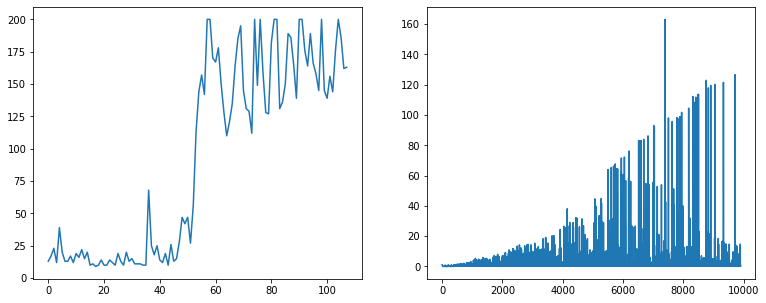

In [7]:
rewards, loss = [], []
episode_reward = 0
state = env.reset()

for i in trange(10000):
  eps = .01 + .99 * math.exp(-i / 500) # close to .01 at 3500
  action = agent.make_final_act(state, eps)
  next_state, reward, done, _ = env.step(action)
  buffer.append((state, action, reward, next_state, done))
  
  state = next_state
  episode_reward += reward
  
  if done:
    state = env.reset()
    rewards.append(episode_reward)
    episode_reward = 0
    
  if i > 100:
    loss.append(agent.train_iter(buffer))
   
  if i > 100 and i % 100 == 0:
    agent.update_targ_net()

plt.figure(figsize=(20,5))
plt.subplot(131)
plt.plot(rewards)
plt.subplot(132)
plt.plot(loss)

Epsilon=0.3

100%|██████████| 10000/10000 [00:19<00:00, 507.85it/s]


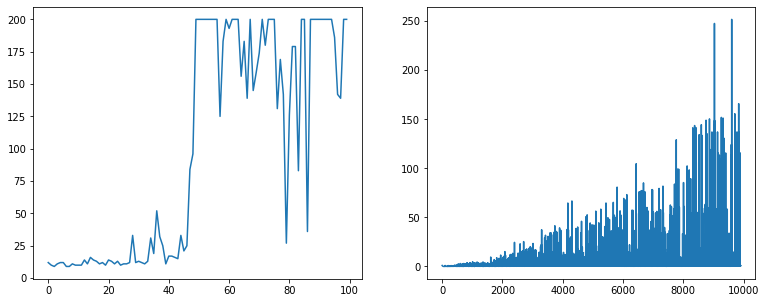

In [12]:
buffer=deque(maxlen=5000)
env = gym.make("CartPole-v0")
agent = agent(epsilon=0.3)
rewards, loss = [], []
episode_reward = 0
state = env.reset()

for i in trange(10000):
  eps = .01 + .99 * math.exp(-i / 500) # close to .01 at 3500
  action = agent.make_final_act(state)
  next_state, reward, done, _ = env.step(action)
  buffer.append((state, action, reward, next_state, done))
  
  state = next_state
  episode_reward += reward
  
  if done:
    state = env.reset()
    rewards.append(episode_reward)
    episode_reward = 0
    
  if i > 100:
    loss.append(agent.train_iter(buffer))
   
  if i > 100 and i % 100 == 0:
    agent.update_targ_net()

plt.figure(figsize=(20,5))
plt.subplot(131)
plt.plot(rewards)
plt.subplot(132)
plt.plot(loss)

Now we set Hidden layer to 32

In [13]:
class deep_qnet(nn.Module):
  # in this part we define some features that describes the arcitecture of DQN

  def __init__(self,input_dim=4,output_dim=2,hidden_layer=32):
    

    super(deep_qnet, self).__init__()

    self.input_dim=input_dim
    self.output_dim=output_dim
    self.hidden=hidden_layer
    self.features=nn.Sequential(
        nn.Linear(self.input_dim,self.hidden),
        nn.ReLU(),
        nn.Linear(self.hidden,self.hidden),
        nn.ReLU()
    )
    self.adv=nn.Linear(self.hidden,self.output_dim)
    self.val = nn.Linear(self.hidden, 1)
  def forward(self,x):
    x=self.features(x)
    adv = self.adv(x)
    val = self.val(x)
    return val + adv - adv.mean(1, keepdim=True)

Hidden 32 and epsilon=0.15

100%|██████████| 10000/10000 [00:18<00:00, 533.22it/s]


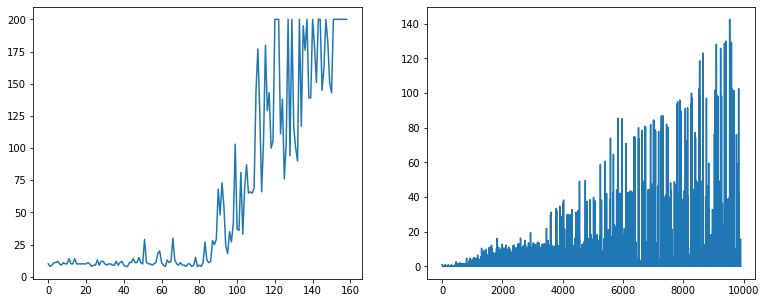

In [16]:
buffer=deque(maxlen=5000)
env = gym.make("CartPole-v0")
agent = agent()
rewards, loss = [], []
episode_reward = 0
state = env.reset()

for i in trange(10000):
  eps = .01 + .99 * math.exp(-i / 500) # close to .01 at 3500
  action = agent.make_final_act(state)
  next_state, reward, done, _ = env.step(action)
  buffer.append((state, action, reward, next_state, done))
  
  state = next_state
  episode_reward += reward
  
  if done:
    state = env.reset()
    rewards.append(episode_reward)
    episode_reward = 0
    
  if i > 100:
    loss.append(agent.train_iter(buffer))
   
  if i > 100 and i % 100 == 0:
    agent.update_targ_net()

plt.figure(figsize=(20,5))
plt.subplot(131)
plt.plot(rewards)
plt.subplot(132)
plt.plot(loss)